In [192]:
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras import Model
from tensorflow.keras.losses import Loss
from tensorflow.keras.layers import Layer, Conv2D, Input
import numpy as np
import matplotlib.pyplot as plt



In [193]:
class MaxPoolingWithArgmax2D(Layer):
    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        ksize = [1, pool_size[0], pool_size[1], 1]
        strides = [1, strides[0], strides[1], 1]
        output, argmax = tf.nn.max_pool_with_argmax(inputs, ksize, strides, 'SAME')
        argmax = tf.cast(argmax, tf.keras.backend.floatx())
        return [output, argmax]

    def compute_output_shape(self, input_shape):
        ratio = (1, 2, 2, 1)
        output_shape = [
            dim // ratio[idx]
            if dim is not None else None
            for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

    def compute_mask(self, inputs, mask=None):
        return 2 * [None]


In [194]:
class MaxUnpooling2D(Layer):
    def __init__(self, up_size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.up_size = up_size
    
    def unpool(self, pool, ind, ksize=[1, 2, 2, 1]):
        input_shape = tf.shape(pool)
        output_shape = [input_shape[0], input_shape[1] * ksize[1], input_shape[2] * ksize[2], input_shape[3]]

        flat_input_size = tf.math.reduce_prod(input_shape)
        flat_output_shape = [output_shape[0], output_shape[1] * output_shape[2] * output_shape[3]]

        pool_ = tf.reshape(pool, [flat_input_size])
        batch_range = tf.reshape(tf.range(tf.cast(output_shape[0], tf.int64), dtype=ind.dtype),
                                          shape=[input_shape[0], 1, 1, 1])
        b = tf.ones_like(ind) * batch_range
        b1 = tf.reshape(b, [flat_input_size, 1])
        ind_ = tf.reshape(ind, [flat_input_size, 1])
        ind_ = tf.concat([b1, ind_], 1)

        ret = tf.scatter_nd(ind_, pool_, shape=tf.cast(flat_output_shape, tf.int64))
        ret = tf.reshape(ret, output_shape)

        set_input_shape = pool.get_shape()
        set_output_shape = [set_input_shape[0], set_input_shape[1] * ksize[1], set_input_shape[2] * ksize[2], set_input_shape[3]]
        ret.set_shape(set_output_shape)
        return ret

    def call(self, inputs, output_shape=None):
        updates = inputs[0]
        mask    = tf.cast(inputs[1], dtype=tf.int64)
        ksize   = [1, self.up_size[0], self.up_size[1], 1]
        return self.unpool(updates, mask, ksize)

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.up_size[0],
            mask_shape[2] * self.up_size[1],
            mask_shape[3]
        )

In [195]:
class Encoder(Model):
    def __init__(self, input_dim):
        super(Encoder, self).__init__()
        self.input_1 = Input(shape=input_dim)
        self.conv1 = Conv2D(16, (5, 5), activation='relu', padding='same')
        self.conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')
        self.max_pool_argmax = MaxPoolingWithArgmax2D(pool_size=(7,7), strides=(7,7))

    def call(self, x):
        #x = self.input_1(x)
        x = self.conv1(x)
        x = self.conv2(x)
        x, mask_1 = self.max_pool_argmax(x)
        L2M_encoder_1 = x
        return x, mask_1, L2M_encoder_1

In [196]:
class Decoder(Model):
    def __init__(self, original_shape):
        super(Decoder, self).__init__()
        #self.input = Input(shape=input_dim)
        self.unpool_1 = MaxUnpooling2D((7,7))
        self.conv_1 = Conv2D(16, (3, 3), activation='relu', padding='same')
        self.conv_2 = Conv2D(1, (5, 5), activation='sigmoid', padding='same')

    def call(self, x):
        L2M_decoder_1 = x[0]
        x = self.unpool_1(x)
        x = self.conv_1(x)
        x = self.conv_2(x)
        return x, L2M_decoder_1

In [197]:
class SWWAE(Model):
    def __init__(self, input_dim):
        super(SWWAE, self).__init__()
        self.encoder = Encoder(input_dim)
        self.decoder = Decoder(input_dim)
    
    def compile(self, optimizer, loss):
        super().compile(optimizer)
        self.loss = loss

    def call(self, x):
        # Forward pass through the encoder and decoder
        encoded, mask_1, L2M_encoder_1 = self.encoder(x)
        decoded, L2M_decoder_1 = self.decoder([encoded, mask_1])
        return decoded, L2M_encoder_1, L2M_decoder_1

In [198]:
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train.astype('float32') / 255., -1)
x_test = np.expand_dims(x_test.astype('float32') / 255., -1)[:10, :, :, :]

In [199]:
x_train.shape

(60000, 28, 28, 1)

In [200]:
# class L2rec_L2M(Loss):
#     def __init__(self, L2rec_lambda=1, L2M_lambda=1):
#         self.L2rec_lambda = L2rec_lambda
#         self.L2M_lambda = L2M_lambda
        
def L2rec_L2M(y_true, y_pred, L2M_encoder_1, L2M_decoder_1):
    l2m_1 = tf.math.square(tf.math.subtract(L2M_encoder_1,L2M_decoder_1))
    L2rec = tf.math.square(tf.math.subtract(y_true,y_pred))
    return tf.math.add(tf.math.reduce_mean(l2m_1),tf.math.reduce_mean(L2rec))

In [201]:
input_dim = (28,28,1)
latent_dim = 2
model = SWWAE(input_dim)
optimizer = tf.optimizers.Adam()
loss = L2rec_L2M
model.compile(loss=loss, optimizer=optimizer)

In [202]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((x_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

epochs = 1
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    # Iterate over the batches of the dataset.
    for step, (x_batch_train) in enumerate(train_dataset):
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:
            prediction, L2M_encoder_1, L2M_decoder_1 = model(x_batch_train, training=True)  # Logits for this minibatch
#             print('L2M_encoder_1',L2M_encoder_1.shape)
#             print('L2M_decoder_1',L2M_decoder_1.shape)
            # Compute the loss value for this minibatch.
            loss_value = loss(x_batch_train, prediction, L2M_encoder_1, L2M_decoder_1)

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))

        # Log every 200 batches.
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))


Start of epoch 0
Training loss (for one batch) at step 0: 0.2304
Seen so far: 32 samples
Training loss (for one batch) at step 200: 0.0105
Seen so far: 6432 samples
Training loss (for one batch) at step 400: 0.0060
Seen so far: 12832 samples
Training loss (for one batch) at step 600: 0.0047
Seen so far: 19232 samples
Training loss (for one batch) at step 800: 0.0036
Seen so far: 25632 samples
Training loss (for one batch) at step 1000: 0.0031
Seen so far: 32032 samples
Training loss (for one batch) at step 1200: 0.0035
Seen so far: 38432 samples
Training loss (for one batch) at step 1400: 0.0028
Seen so far: 44832 samples
Training loss (for one batch) at step 1600: 0.0025
Seen so far: 51232 samples
Training loss (for one batch) at step 1800: 0.0024
Seen so far: 57632 samples


1/1 [==============================] - 0s 35ms/step
(10, 56, 28, 1)


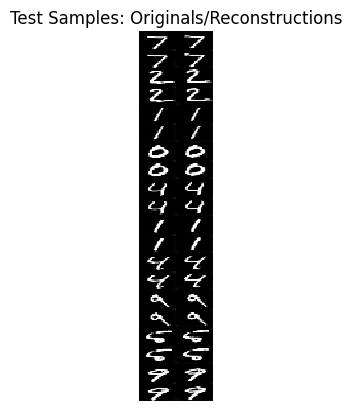

In [206]:
x_recon = model.predict(x_test[:25])
x_plot = np.concatenate((x_test[:25], x_recon[0]), axis=1)
print(x_plot.shape)
x_plot = x_plot.reshape((28,1,10,56))
x_plot = np.vstack([np.hstack(x) for x in x_plot])
plt.figure()
plt.axis('off')
plt.title('Test Samples: Originals/Reconstructions')
plt.imshow(x_plot, interpolation='none', cmap='gray')
plt.savefig('reconstructions.png')